# Train LSTM model to Enduro sequence games

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *
import matplotlib.pyplot as plt
import time

## Set to GPU if available

In [2]:
use_gpu = input("Use GPU (y/n) ")
if use_gpu == 'y':
    use_gpu = True
else:
    use_gpu = False

Use GPU (y/n) y


In [3]:
device = conf_cuda(use_gpu)

GPU is available


In [4]:
if use_gpu:
    torch.cuda.empty_cache()

## Set configurations

In [5]:
obs = 'play'
if obs == 'zigzag':
    zigzag = True
else:
    zigzag = False
zigzag

False

In [6]:
data_path = r"../1-generate/data/"
n_epochs = 5000
hidden_neurons = 200
stop_train = 1e-5

start_match = 45
end_match = 50

start_frame = 1
end_frame = 1000

In [7]:
model_name = f"{obs}_m{start_match}to{end_match}_f{start_frame}to{end_frame}_epoch{n_epochs}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name + " created")
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/play_m45to50_f1to1000_epoch5000_H200
ATTENTION! folder not created. Training informations will overwrite the existing one


## Load frames and targets

In [8]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)
ACTIONS_LIST

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [9]:
num_of_frames_arr = []
frames_arr = []
actions_arr = []

for m in range(start_match, end_match + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.


In [10]:
data = np.array(frames_arr)/255
targets = np.array(actions_arr)
num_of_frames_arr = np.array(num_of_frames_arr)

In [11]:
data = torch.tensor(data).float()
targets = torch.tensor(targets).float()

## Create model

In [14]:
model = Model(device=device, input_size=20400, output_size=len(ACTIONS_LIST), hidden_dim=hidden_neurons, n_layers=1)

In [15]:
# We'll also set the model to the device that we defined earlier (default is CPU)
if use_gpu:
    model.cuda()
    data = data.cuda() 
    targets = targets.cuda()

In [16]:
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())

## Model train

In [17]:
def get_acc(predicted, target):
    
    predicted = torch.argmax(predicted, axis=1)
    target = torch.argmax(target, axis=1)
    
    correct = torch.sum(predicted == target)
    
    acc = correct/predicted.shape[0]
    return float(acc)

In [18]:
def print_epoch(epoch, n_epochs, train_loss, train_acc, valid_loss, valid_acc):
    print('Epoch: {}/{}-------------------------------------------'.format(epoch, n_epochs))
    print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss, train_acc))
    print("Valid -> Loss: {:.15f} Acc: {:.15f}".format(valid_loss, valid_acc))

In [28]:
train_idx = np.setdiff1d([0,1], 1)
X_train[train_idx].shape

torch.Size([1, 1000, 20400])

In [ ]:
all_idx = np.arange(len(data))
for epoch in range(1, n_epochs + 1):

    for valid_idx in range(len(data)):
        
        train_idx = np.setdiff1d(all_idx, train_idx)
        X_train = data[train_idx]
        Y_train = targets[train_idx]
        X_valid = data[valid_idx]
        Y_valid = targets[valid_idx]
    
        model.train()

        optimizer.zero_grad() # Clears existing gradients from previous epoch
        X_train.to(device)
        output, hidden = model(X_train)
        loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordinglyw
        
        if epoch%10 == 0:

            train_loss_arr = np.append(train_loss_arr, loss.item())
            train_acc_arr  = np.append(train_acc_arr, get_acc(output, Y_train.reshape(-1, len(ACTIONS_LIST))))

            model.eval()

            epoch_valid_losses = np.array([])
            epoch_valid_acc = np.array([])
            
            output, hidden = model(X_valid)
            loss = criterion(output, Y_valid.view(-1,len(ACTIONS_LIST)).float())
            epoch_valid_losses = np.append(epoch_valid_losses, loss.item())
            epoch_valid_acc = np.append( epoch_valid_acc, get_acc(output, Y_valid.reshape(-1, len(ACTIONS_LIST))) )

            if first_epoch:
                valid_loss_arr = epoch_valid_losses.reshape(-1, 1)
                valid_acc_arr = epoch_valid_acc.reshape(-1, 1)
                first_epoch = False
            else:
                valid_loss_arr = np.insert(valid_loss_arr, valid_loss_arr.shape[1], epoch_valid_losses, axis=1)
                valid_acc_arr = np.insert(valid_acc_arr, valid_acc_arr.shape[1], epoch_valid_acc, axis=1)

            valid_loss_mean_arr = np.append(valid_loss_mean_arr, np.mean(epoch_valid_losses))
            valid_acc_mean_arr = np.append(valid_acc_mean_arr, np.mean(epoch_valid_acc))

            loss_file.write("Epoch: {}/{}-------------------------------------------\n".format(epoch, n_epochs))
            loss_file.write("Train -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss_arr[-1], train_acc_arr[-1]))
            loss_file.write("Valid -> Loss: {:.15f} Acc: {:.15f}\n".format(valid_loss_mean_arr[-1], valid_acc_mean_arr[-1]))

            print("Epoch: {}/{}-------------------------------------------".format(epoch, n_epochs))
            print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss_arr[-1], train_acc_arr[-1]))
            print("Valid -> Loss: {:.15f} Acc: {:.15f}".format(valid_loss_mean_arr[-1], valid_acc_mean_arr[-1]))

            if train_loss_arr[-1] < best_loss:
                state = { 'epoch': epoch + 1, 'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(), 'losslogger': loss.item(), }
                torch.save(state, newpath + '/' + model_name)
                best_loss = loss.item()
            else:
                print("model not saved")

            if (valid_loss_mean_arr[-1] < min_loss):
                break
        
loss_file.close()
np.savez(newpath + '/' + "train_loss_arr", train_loss_arr)
np.savez(newpath + '/' + "valid_loss_arr", valid_loss_arr)
np.savez(newpath + '/' + "valid_loss_mean_arr", valid_loss_mean_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

Epoch: 1/5000-------------------------------------------
Train -> Loss: 0.088802665472031 Acc: 0.750000000000000
Valid -> Loss: 0.054896760731936 Acc: 0.750000000000000
Epoch: 2/5000-------------------------------------------
Train -> Loss: 0.082058683037758 Acc: 0.750000000000000
Valid -> Loss: 0.056073226034641 Acc: 0.750000000000000
Epoch: 3/5000-------------------------------------------
Train -> Loss: 0.075361080467701 Acc: 0.750000000000000
Valid -> Loss: 0.057496353983879 Acc: 0.750000000000000
Epoch: 4/5000-------------------------------------------
Train -> Loss: 0.068789318203926 Acc: 0.750000000000000
Valid -> Loss: 0.059159066528082 Acc: 0.750000000000000
Epoch: 5/5000-------------------------------------------
Train -> Loss: 0.062418837100267 Acc: 0.750000000000000
Valid -> Loss: 0.061049349606037 Acc: 0.750000000000000
Epoch: 6/5000-------------------------------------------
Train -> Loss: 0.056318171322346 Acc: 0.241666659712791
Valid -> Loss: 0.063150130212307 Acc: 0.25

Epoch: 50/5000-------------------------------------------
Train -> Loss: 0.001920010661706 Acc: 0.250000000000000
Valid -> Loss: 0.128125220537186 Acc: 0.250000000000000
Epoch: 51/5000-------------------------------------------
Train -> Loss: 0.001874758163467 Acc: 0.250000000000000
Valid -> Loss: 0.128445073962212 Acc: 0.250000000000000
Epoch: 52/5000-------------------------------------------
Train -> Loss: 0.001832225127146 Acc: 0.250000000000000
Valid -> Loss: 0.128749787807465 Acc: 0.250000000000000
Epoch: 53/5000-------------------------------------------
Train -> Loss: 0.001792160328478 Acc: 0.250000000000000
Valid -> Loss: 0.129040569067001 Acc: 0.250000000000000
Epoch: 54/5000-------------------------------------------
Train -> Loss: 0.001754340482876 Acc: 0.250000000000000
Valid -> Loss: 0.129318401217461 Acc: 0.250000000000000
Epoch: 55/5000-------------------------------------------
Train -> Loss: 0.001718565472402 Acc: 0.250000000000000
Valid -> Loss: 0.129584327340126 Acc

Epoch: 99/5000-------------------------------------------
Train -> Loss: 0.000954203133006 Acc: 0.250000000000000
Valid -> Loss: 0.136239871382713 Acc: 0.250000000000000
Epoch: 100/5000-------------------------------------------
Train -> Loss: 0.000944554922171 Acc: 0.250000000000000
Valid -> Loss: 0.136342301964760 Acc: 0.250000000000000
Epoch: 101/5000-------------------------------------------
Train -> Loss: 0.000935071730055 Acc: 0.250000000000000
Valid -> Loss: 0.136443689465523 Acc: 0.250000000000000
Epoch: 102/5000-------------------------------------------
Train -> Loss: 0.000925749249291 Acc: 0.250000000000000
Valid -> Loss: 0.136544093489647 Acc: 0.250000000000000
Epoch: 103/5000-------------------------------------------
Train -> Loss: 0.000916579039767 Acc: 0.250000000000000
Valid -> Loss: 0.136643484234810 Acc: 0.250000000000000
Epoch: 104/5000-------------------------------------------
Train -> Loss: 0.000907562673092 Acc: 0.250000000000000
Valid -> Loss: 0.13674196600914

Epoch: 147/5000-------------------------------------------
Train -> Loss: 0.000623629137408 Acc: 0.250000000000000
Valid -> Loss: 0.140275970101357 Acc: 0.250000000000000
Epoch: 148/5000-------------------------------------------
Train -> Loss: 0.000618803198449 Acc: 0.250000000000000
Valid -> Loss: 0.140345185995102 Acc: 0.250000000000000
Epoch: 149/5000-------------------------------------------
Train -> Loss: 0.000614037096966 Acc: 0.250000000000000
Valid -> Loss: 0.140413895249367 Acc: 0.250000000000000
Epoch: 150/5000-------------------------------------------
Train -> Loss: 0.000609330309089 Acc: 0.250000000000000
Valid -> Loss: 0.140482112765312 Acc: 0.250000000000000
Epoch: 151/5000-------------------------------------------
Train -> Loss: 0.000604681205004 Acc: 0.250000000000000
Valid -> Loss: 0.140549927949905 Acc: 0.250000000000000
Epoch: 152/5000-------------------------------------------
Train -> Loss: 0.000600088387728 Acc: 0.250000000000000
Valid -> Loss: 0.1406172364950

Epoch: 195/5000-------------------------------------------
Train -> Loss: 0.000445407000370 Acc: 0.250000000000000
Valid -> Loss: 0.143134951591492 Acc: 0.250000000000000
Epoch: 196/5000-------------------------------------------
Train -> Loss: 0.000442598800873 Acc: 0.250000000000000
Valid -> Loss: 0.143185988068581 Acc: 0.250000000000000
Epoch: 197/5000-------------------------------------------
Train -> Loss: 0.000439819938038 Acc: 0.250000000000000
Valid -> Loss: 0.143236756324768 Acc: 0.250000000000000
Epoch: 198/5000-------------------------------------------
Train -> Loss: 0.000437069422333 Acc: 0.250000000000000
Valid -> Loss: 0.143287211656570 Acc: 0.250000000000000
Epoch: 199/5000-------------------------------------------
Train -> Loss: 0.000434345449321 Acc: 0.250000000000000
Valid -> Loss: 0.143337398767471 Acc: 0.250000000000000
Epoch: 200/5000-------------------------------------------
Train -> Loss: 0.000431649037637 Acc: 0.250000000000000
Valid -> Loss: 0.1433873027563

Epoch: 243/5000-------------------------------------------
Train -> Loss: 0.000337012606906 Acc: 0.250000000000000
Valid -> Loss: 0.145296379923820 Acc: 0.250000000000000
Epoch: 244/5000-------------------------------------------
Train -> Loss: 0.000335220945999 Acc: 0.250000000000000
Valid -> Loss: 0.145335987210274 Acc: 0.250000000000000
Epoch: 245/5000-------------------------------------------
Train -> Loss: 0.000333444011630 Acc: 0.250000000000000
Valid -> Loss: 0.145375341176987 Acc: 0.250000000000000
Epoch: 246/5000-------------------------------------------
Train -> Loss: 0.000331682473188 Acc: 0.250000000000000
Valid -> Loss: 0.145414546132088 Acc: 0.250000000000000
Epoch: 247/5000-------------------------------------------
Train -> Loss: 0.000329935108311 Acc: 0.250000000000000
Valid -> Loss: 0.145453542470932 Acc: 0.250000000000000
Epoch: 248/5000-------------------------------------------
Train -> Loss: 0.000328203284880 Acc: 0.250000000000000
Valid -> Loss: 0.1454923301935

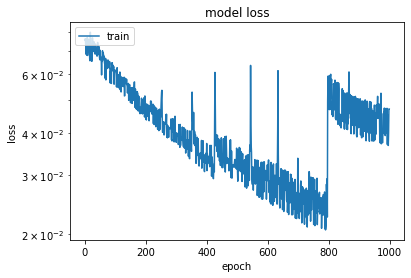

In [16]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.clf()
plt.plot(train_loss_arr, color='blue')
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'train_loss.png')

In [ ]:
# summarize history for loss
plt.clf()
plt.plot(valid_loss_mean_arr, color='blue')
plt.title('model valid loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valid'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'valid_loss_mean.png')

In [56]:
for seq in range(len(X_train)):
    # summarize history for loss
    plt.clf()
    plt.plot(valid_loss_arr[seq], color='blue')
    plt.title('model valid loss ' + str(seq))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['valid'], loc='upper left')
    plt.yscale('log')
    plt.savefig(newpath + '/' + f'valid_loss_{seq}.png')